注意力机制：根据query和key去有偏向性的选择输入 -> 注意力池化：根据query去有偏向的选择key value pair
（query：随意线索/ key：不随意线索/ value：每个输入的值）
卷积、全连接、池化层都只考虑不随意线索
明显的去建模随意线索
通过注意力池化层来有偏向性的选择某些输入
—— 非参数注意力池化：找离Truth近的点，增大权重 进行预测
pros：不需要学习，理论证明：足够的数据支撑 预测可以达到最佳 得出原始模型
cons：现实生活中没有足够的数据，预测曲线过于平滑
—— 带参数注意力池化：
pros：由于数据集小，需要窄一点的窗口，导致预测曲线不平滑 靠近真实曲线 -> 拟合度高
cons：噪音大

In [1]:
# 注意力池化：Nadaraya-Watson 核回归实现
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
n_train = 50
# 训练集：0～5之间随机生成50个数，然后排序
x_train, _ = torch.sort(torch.rand(n_train) * 5)

# 真实的函数
def f(x):
    return 2*torch.sin(x)+x**0.8

# 拟合
# y_train：用来训练的label<-真实函数+高斯噪音
# f(x_train)：真实函数，torch.normal(0.0, 0.5, (n_train, ))：方差为0.5的高斯噪音
y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train, ))
x_test = torch.arange(0, 5, 0.1)
# 真实值，目标：给定X_test来预测y_truth
y_truth = f(x_test)
n_test = len(x_test)

n_test

50

In [3]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)

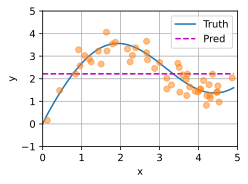

In [4]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

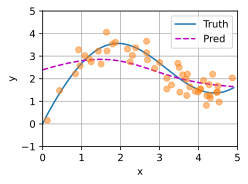

In [5]:
# 非参数注意力池化：找离Truth近的点，增大权重 进行预测 => 预测曲线平滑的加权回归
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat= x_test.repeat_interleave(n_train).reshape((-1, n_train))
# x_train包含key，attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat-x_train)**2/ 2, dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
# 预测 = 权重 * y_train
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

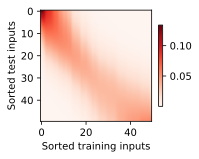

In [6]:
# 学习到的权重：权重较散，中间一部分：分的权重比较均匀，越靠两边深色的 权重越集中，中间比较平滑
d2l.show_heatmaps(
    attention_weights.unsqueeze(0).unsqueeze(0),
    xlabel='Sorted training inputs', ylabel='Sorted test inputs'
)

In [7]:
# 带参数注意力池化：
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))

# 矩阵乘法：(n, a, b)@(n, b, c) = (n, a, c)
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [8]:
weights = torch.ones((2, 10))*0.1
values = torch.arange(20.0).reshape((2, 10))
# 使用小批量矩阵乘法来计算小批量数据中的加权平均值
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

In [9]:
# 带参数的注意力汇聚：预测曲线不平滑 拟合结果好很多，但是噪音大
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1, ), requires_grad=True))
        
    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            # 与非参数注意力池化的区别：加了w，w：控制高斯核 -> 窗口的大小
            -((queries-keys) * self.w)**2/ 2, dim=1)
        
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)
        

In [10]:
# 将训练数据集转换为key 和 value
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

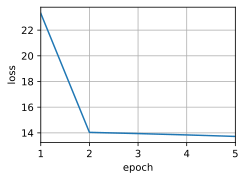

In [13]:
# 训练带参数的注意力池化模型
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch+1}, loss {float(l.sum()): .6f}')
    animator.add(epoch+1, float(l.sum()))

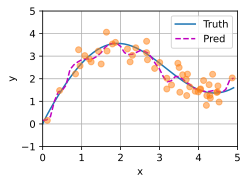

In [14]:
# 预测结果绘制：由于数据集小，需要窄一点的窗口，导致预测曲线不平滑
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

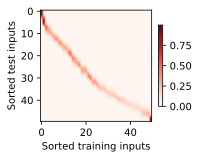

In [15]:
# 学习到的权重：曲线在注意力权重较大的区域变得不平滑
# 每一次测试的时候给对应的训练样本分的权重相对集中，只给跟x较近的xi较大的权重 其余的权重相对较小
# 通过学习w 使得注意力权重训练的更好 -> 拟合的更好
d2l.show_heatmaps(
    net.attention_weights.unsqueeze(0).unsqueeze(0),
    xlabel='Sorted training inputs', ylabel='Sorted test inputs'
)